In [1]:
#!pip install scikit-learn
#!pip install seaborn
#!pip install opencv-python

import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                  
from random import randint               
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential  
import tensorflow as tf            
from tqdm import tqdm

In [2]:
class_names = ['marah', 'terkejut', 'normal', 'senyum']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

# IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (120, 120)
# IMAGE_SIZE_2 = (120, 120)

In [3]:
def load_data():
    """
        Load the data:
            - 96 images to train the network.
            - 40 images to evaluate how accurately the network learned to classify images.
    """
    filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    datasets = ['dataset_rgb/train', 'dataset_rgb/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                # image = image[35:224, 35:190]
                image = cv2.filter2D(image,-1,filter)
                # image = cv2.resize(image,(120,120)) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

 24%|███████████████████▏                                                            | 24/100 [00:00<00:00, 238.26it/s]

Loading dataset_rgb/train


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Loading dataset_rgb/test


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 247.59it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
# Exploring Datasets

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 400
Number of testing examples: 80
Each image is of size: (120, 120)


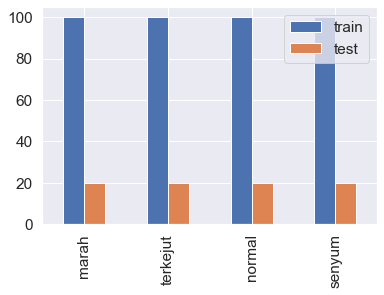

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

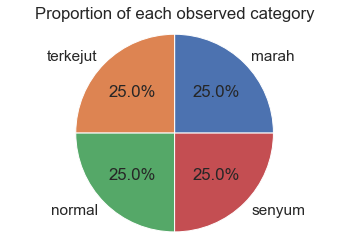

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%'
        )
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
# Data Normalization

train_images = train_images / 255.0 
test_images = test_images / 255.0

In [10]:
# Visualize the Data

def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [11]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

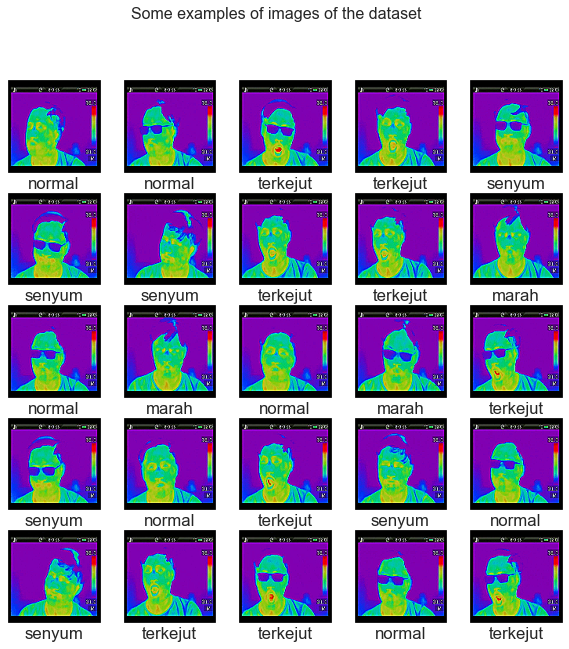

In [12]:
display_examples(class_names, train_images, train_labels)

In [13]:
# CNN models

model = Models.Sequential()

model.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(120, 120, 3)))
model.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(2,2))

model.add(Layers.Flatten())

model.add(Layers.Dense(256,activation='relu'))
model.add(Layers.Dropout(0.5))
model.add(Layers.Dense(4,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# Utils.plot_model(model,to_file='model.png',show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 58, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 215296)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               55116032  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [14]:
history = model.fit(train_images, 
                    train_labels, 
                    batch_size=16, 
                    epochs=15, 
                    validation_split=0.2
                    )

# If train accuracy < validation accuracy, please STOP model training process.

Epoch 1/15
20/20 [==============================] - 11s 394ms/step - loss: 1.3668 - accuracy: 0.3335 - val_loss: 1.1915 - val_accuracy: 0.5000
Epoch 2/15
20/20 [==============================] - 7s 343ms/step - loss: 1.1597 - accuracy: 0.5121 - val_loss: 1.0202 - val_accuracy: 0.6625
Epoch 3/15
20/20 [==============================] - 7s 344ms/step - loss: 1.0161 - accuracy: 0.5872 - val_loss: 0.9017 - val_accuracy: 0.6125
Epoch 4/15
20/20 [==============================] - 7s 344ms/step - loss: 0.8381 - accuracy: 0.6755 - val_loss: 0.7675 - val_accuracy: 0.8625
Epoch 5/15
20/20 [==============================] - 7s 344ms/step - loss: 0.7378 - accuracy: 0.7716 - val_loss: 0.6918 - val_accuracy: 0.8625
Epoch 6/15
20/20 [==============================] - 7s 344ms/step - loss: 0.6398 - accuracy: 0.8415 - val_loss: 0.5881 - val_accuracy: 0.9375
Epoch 7/15
20/20 [==============================] - 7s 344ms/step - loss: 0.6197 - accuracy: 0.8396 - val_loss: 0.5162 - val_accuracy: 0.9500
Epoch

In [24]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,6))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

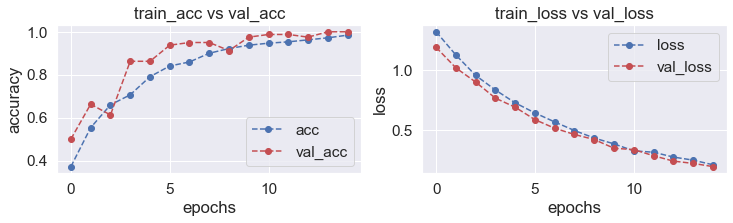

In [25]:
plot_accuracy_loss(history)

In [17]:
test_loss = model.evaluate(test_images, test_labels)

3/3 [==============================] - 1s 84ms/step - loss: 0.4488 - accuracy: 0.8625


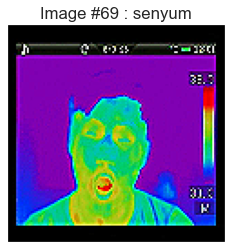

In [18]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [19]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

IndexError: index 11 is out of bounds for axis 0 with size 11

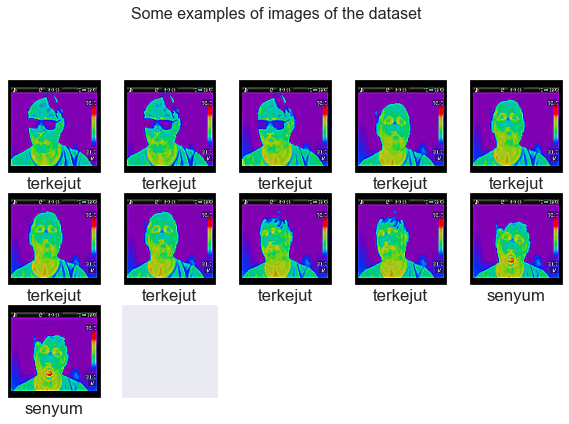

In [20]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

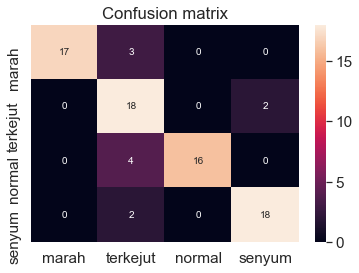

In [21]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()